# Bayesian Online Changepoint Detection
* It is a probabilistic model to identify the level shifts(mean-shifts) or variational shifts in incoming dataset
* It predicts posterior probability of run length(interval between to changepoints in dataset) so for a dataset of n-samples, there are n-possible run lengths.
* The model calculates probability that all those possible run lengths for each datapoint to be changepoints so it creates $NxN$ matrix where $N$ is length of the dataset
* So we set default threshold probability for it be a changepoint is $0.5$.

## Required Arguments to run the program:

* All of the algorithm related parameters are optional which has a default value given in the program itself.
* Description for each argument is given below :

* algo_kwargs={
            'data_col_index':1  -> column index from which metrics to be considered for anomaly detection ,
            'pthres':thres_prob -> probability after which a point is considered as changepoint,
            'Nw':samples_to_wait -> samples to wait before detecting changepoints,
            'mean_runlen':expected_run_length -> average run length between two change points in dataset
        }
        
* So the default value given are as follows:
     * algo_kwargs={
            'data_col_index':1,
            'pthres':0.5,
            'Nw':10,
            'mean_runlen':100
        }

## Dependencies :
* Download https://github.com/hildensia/bayesian_changepoint_detection this and run **python setup.py install** to install the bayesian changepoint detection module.
* Install **writefile_run** using pip , which is used to save the cell in a python file automatically

In [1]:
import writefile_run as writefile_run

In [2]:
filename = '../../anomaly_detectors/bayesian_detector/bayeschangept_wrapper.py'

In [3]:
%%writefile_run $filename

'''
importing all the required header files
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os

from anomaly_detectors.utils.data_handler import  *
from anomaly_detectors.utils.preprocessors import *
from anomaly_detectors.utils.error_codes import error_codes
from anomaly_detectors.utils import type_checker as type_checker
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.utils import make_ackg_json
from anomaly_detectors.bayesian_detector import bayesian_changept_detector

import json
import traceback
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
%%writefile_run $filename -a

'''
ideal argument types for algorithm
'''
algo_params_type ={
            'data_col_index':int,
            'pthres':float or int,
            'Nw':int,
            'mean_runlen':int,
            'to_plot':bool
        }

In [6]:
%%writefile_run $filename -a


def main(filepath,thres_prob=0.5,samples_to_wait=10,expected_run_length=100,to_plot=True):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        
        *reader           - Class Data_reader defined in data_handler.py which takes in filepath as string as 
                            input and groups the dataframe into list of dataframes, incase of any error it 
                            returns dictionary with error message
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *make_ack_json    - Function to make acknowledge json
        
        
        Arguments :
        
        Required Parameter:
            reader_kwargs: the Json object in the format of the input json given from reader api
        Optional Parameter:
            thres_prob (Type : Float , between 0 and 1) It is the probability threshold after which points are considered as change points
            Default: 0.5
            samples_to_wait: Positive Integer representing the no of samples after which the run length probability will be calculated. It is one of the algorithm related parameter
            Default: 10
            expected_run_length: positive Integer that is average run length or no of samples between two change-points. This originates from modeling the interval between change-points with exponential distribution
            Default : 100
            to_plot : Boolean .Give True to see the plots of change-points detected and False if there is no need for plotting
            Default : True
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        

        #algorithm arguments
        algo_kwargs={
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length,
            'to_plot':to_plot
        }
              
        '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
        '''
        error_codes1 = error_codes()
        
        try: 
                       
            
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=algo_params_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return json.dumps(res)
            
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(filepath=filepath)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = pd.unique(data_per_asset['assetno'])[0]

                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])
                    print("Overview of data : \n{}\n".format(data_per_asset.head()))

                    for data_col in range(1,len(data_per_asset.columns[1:])+1):
                        algo_kwargs['data_col_index'] = data_col
                        print("\nAnomaly detection for AssetNo : {} ,Metric : {}\n ".format(
                            assetno,data_per_asset.columns[data_col]))
                        
                        anomaly_detector = bayesian_changept_detector.Bayesian_Changept_Detector(data_per_asset,
                                                                                                 assetno=assetno,
                                                                                                 **algo_kwargs)
                        data,anom_indexes = anomaly_detector.detect_anomalies()

                        anomaly_detectors.append(anomaly_detector)
                        
                ack_json = {}
                ack_json = make_ackg_json.make_ack_json(anomaly_detectors)
                        
                return json.dumps(ack_json)
            elif(type(entire_data)==dict):
                return json.dumps(entire_data)
            else:
                '''
                Data empty errors
                '''
                return json.dumps(error_codes1['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            
            error_codes1['unknown']['message']=str(e)
            return json.dumps(error_codes1['unknown'])

In [7]:
reader_kwargs = lambda :{
            'filepath'   :'../../dataset/sample_csv_files/alcohol-demand-log-spirits-consu.csv',
            'filename'   :'alcohol-demand-log-spirits-consu.csv',
            'target_dir' :'../../dataset/reader_csv_files/',
            'assetno'    :'A1',
            'n_rows'     :None,
            'has_time'   :True
            }

algo_kwargs =lambda: {
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100,
            'to_plot':True
            }

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
               assetno  \
timestamp                
-3147897600000      A1   
-3137356800000      A1   
-3126816000000      A1   
-3116361600000      A1   
-3105820800000      A1   

                Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                         
-3147897600000                                           0.026580                 
-3137356800000                                           0.114869                 
-3126816000000                                           0.247302                 
-3116361600000                                           0.379735                 
-3105820800000                                           0.423880                 


Anomaly detection for AssetNo : A1 ,Metric : Alcohol demand (log spirits consumption per head), UK, 1870-1938
 
Shape of the dataset : 
(207, 2)


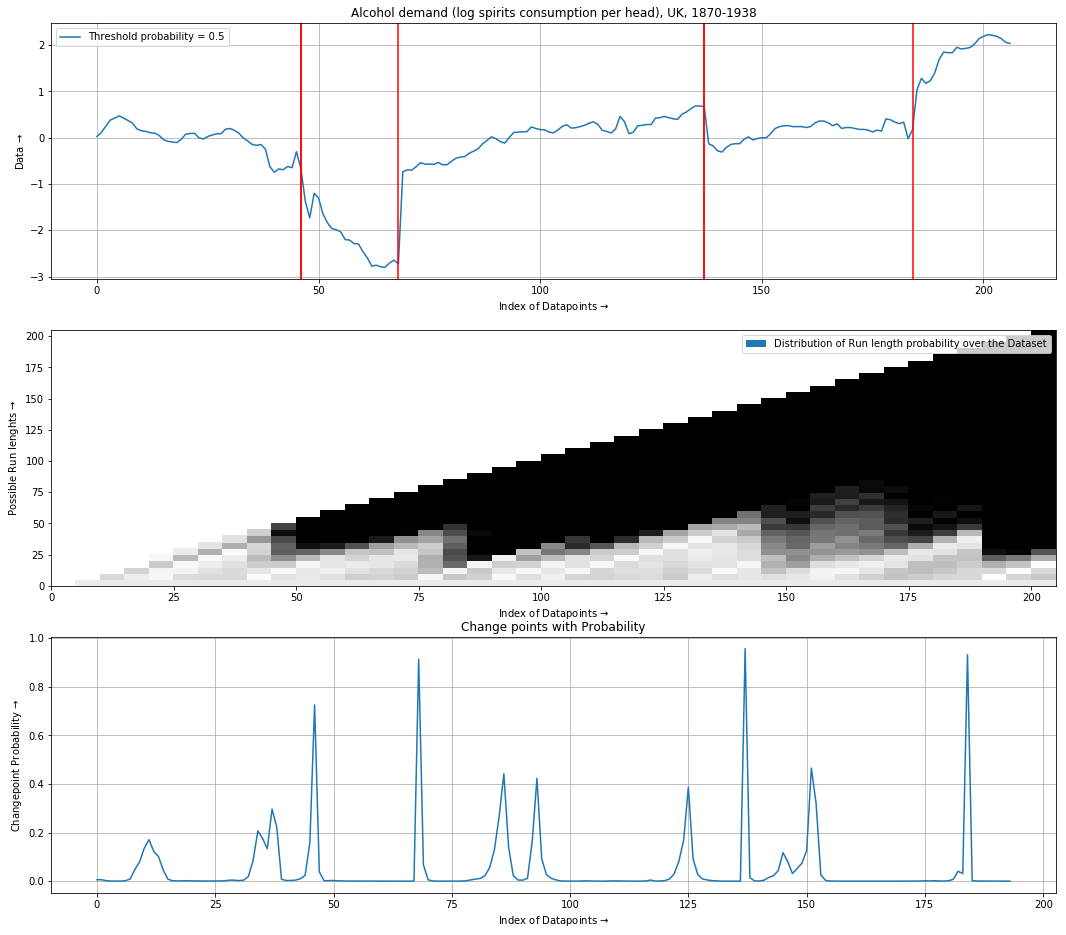


 No of Anomalies detected = 6
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "A1", "anomalies": [{"name": "Alcohol demand (log spirits consumption per head), UK, 1870-1938", "datapoints": [{"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2432505600000, "to_timestamp": -2432505600000, "anomaly_timestamp": [-2432505600000], "anomaly_code": "bcp"}, {"from_timestamp": -1706832000000, "to_timestamp": -1706832000000, "anomaly_timestamp": [-1706832000000], "anomaly_code": "bcp"}, {"from_timestamp": -1706832000000, "to_timestamp": -1706832000000, "anomaly_timestamp": [-1706832000000], "anomaly_code": "bcp"}, {"from_timestamp": -1212451200000, "to_timestamp": -1212451200000, "anomaly_timestamp": [-1212451200000], "anomaly_code": "bcp"}]}]}]}


In [8]:
'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints 
and gives output json of anomaly timestamps
'''

reader_kwargs1 = reader_kwargs()
filepath,feature_names = csv_helper.preparecsvtoread(**reader_kwargs1)
algo_kwargs1 = algo_kwargs()
res = main(filepath=filepath,**algo_kwargs1)
print(res)

## Testing the algo on sample csv datasets


Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
           assetno       CO2   Methane
timestamp                             
7808400000      A1  0.090839 -1.170356
7808940000      A1  0.028381 -1.340206
7809480000      A1 -0.002849 -1.062837
7810020000      A1 -0.002849 -0.811959
7810560000      A1 -0.034078 -0.758978


Anomaly detection for AssetNo : A1 ,Metric : CO2
 
Shape of the dataset : 
(296, 3)


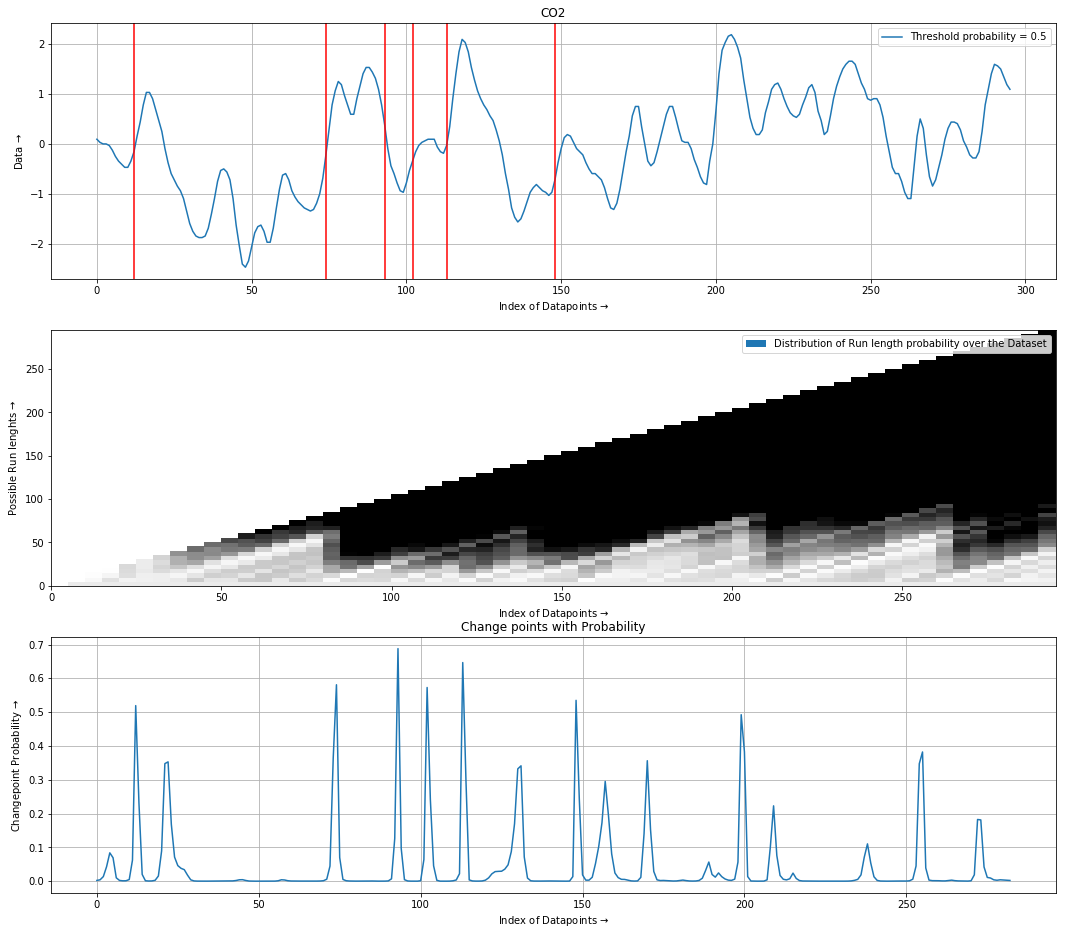


 No of Anomalies detected = 6

Anomaly detection for AssetNo : A1 ,Metric : Methane
 
Shape of the dataset : 
(296, 3)


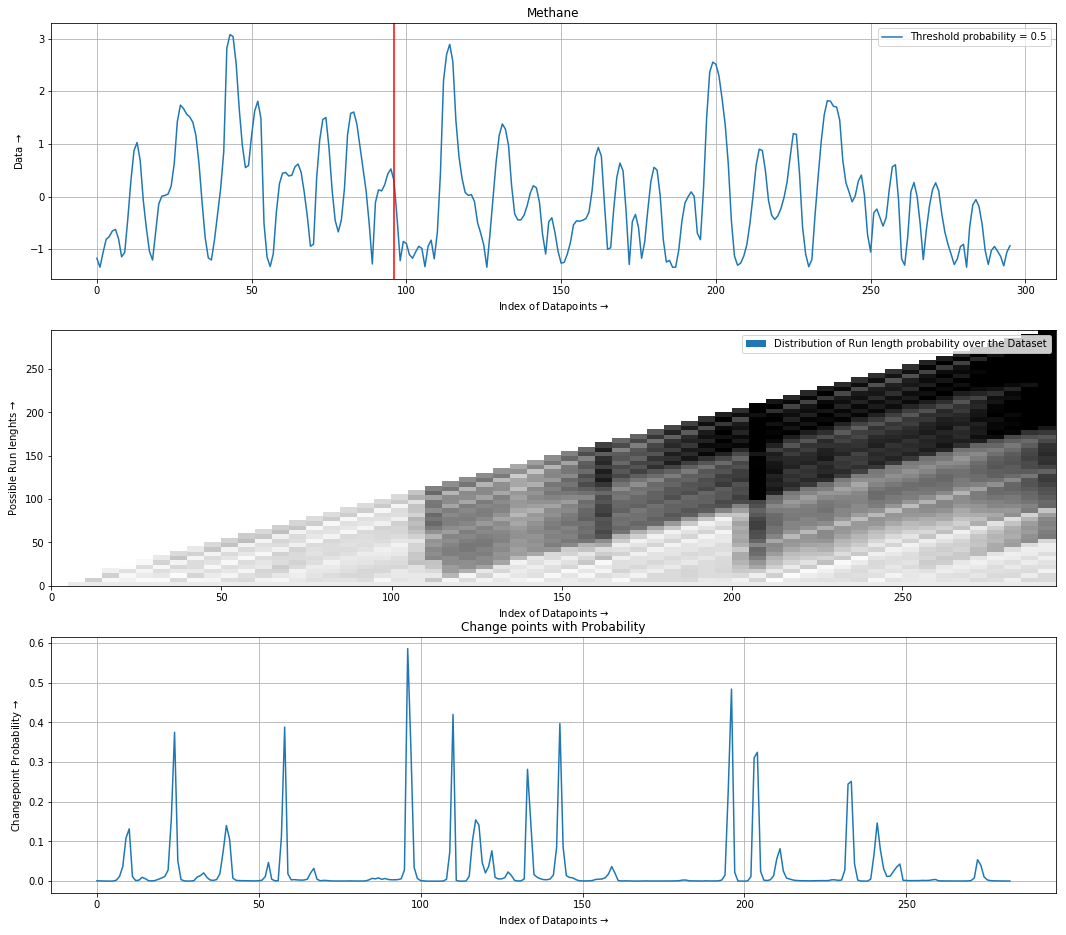


 No of Anomalies detected = 1
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "A1", "anomalies": [{"name": "CO2", "datapoints": [{"from_timestamp": 7814880000, "to_timestamp": 7814880000, "anomaly_timestamp": [7814880000], "anomaly_code": "bcp"}, {"from_timestamp": 7848360000, "to_timestamp": 7848360000, "anomaly_timestamp": [7848360000], "anomaly_code": "bcp"}, {"from_timestamp": 7858620000, "to_timestamp": 7858620000, "anomaly_timestamp": [7858620000], "anomaly_code": "bcp"}, {"from_timestamp": 7863480000, "to_timestamp": 7863480000, "anomaly_timestamp": [7863480000], "anomaly_code": "bcp"}, {"from_timestamp": 7869420000, "to_timestamp": 7869420000, "anomaly_timestamp": [7869420000], "anomaly_code": "bcp"}, {"from_timestamp": 7888320000, "to_timestamp": 7888320000, "anomaly_timestamp": [7888320000], "anomaly_code": "bcp"}]}, {"name": "Methane", "datapoints": [{"from_timestamp": 7860240000, "to_timestamp": 7860240000, "anomaly_timestamp": [7860240000], "anomaly_code": 

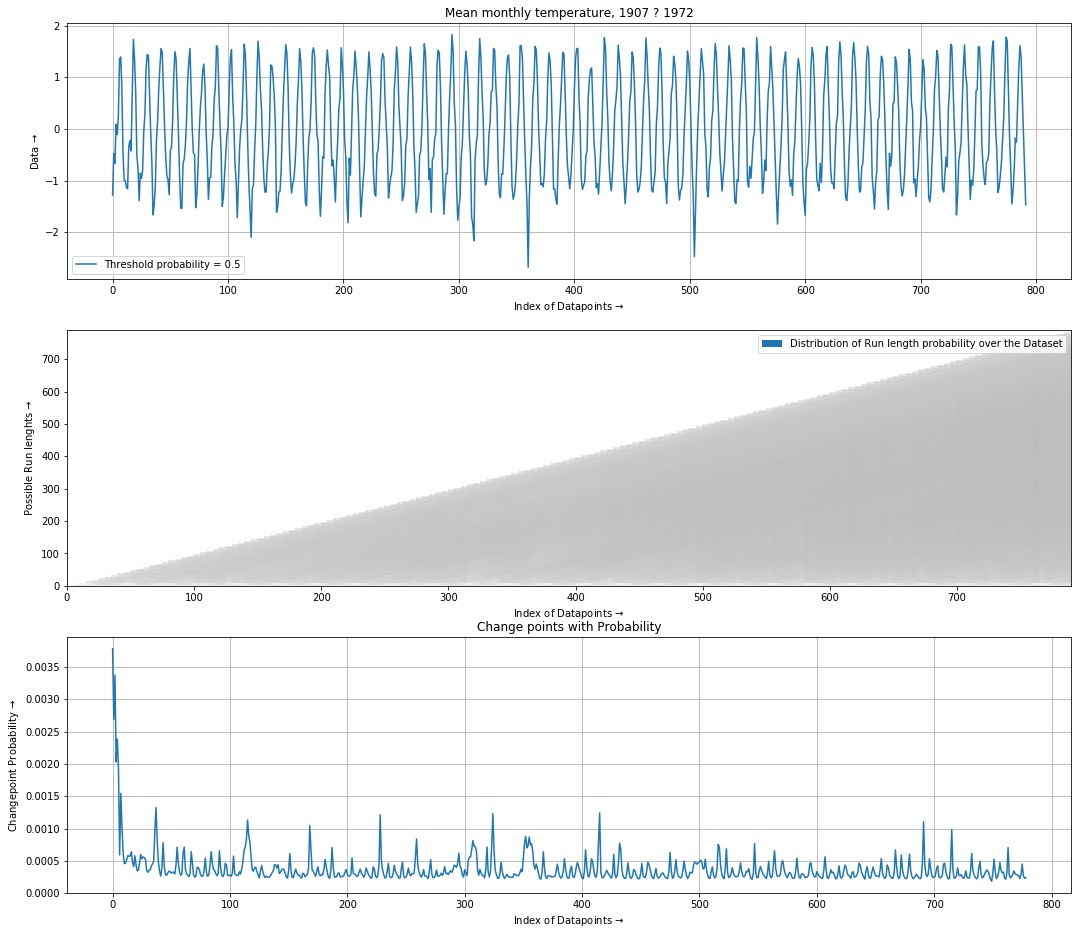


 No of Anomalies detected = 0
{"header": {"code": "200", "status": "OK", "message": "No Anomalies detected"}, "body": []}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
              assetno  \
timestamp               
-694310400000      A1   
-691632000000      A1   
-689126400000      A1   
-686448000000      A1   
-683856000000      A1   

               Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981  
timestamp                                                                                      
-694310400000                                          -1.351533                               
-691632000000                                          -1.054180                               
-689126400000                                          -1.138722                               
-686448000000                                          -1.183908       

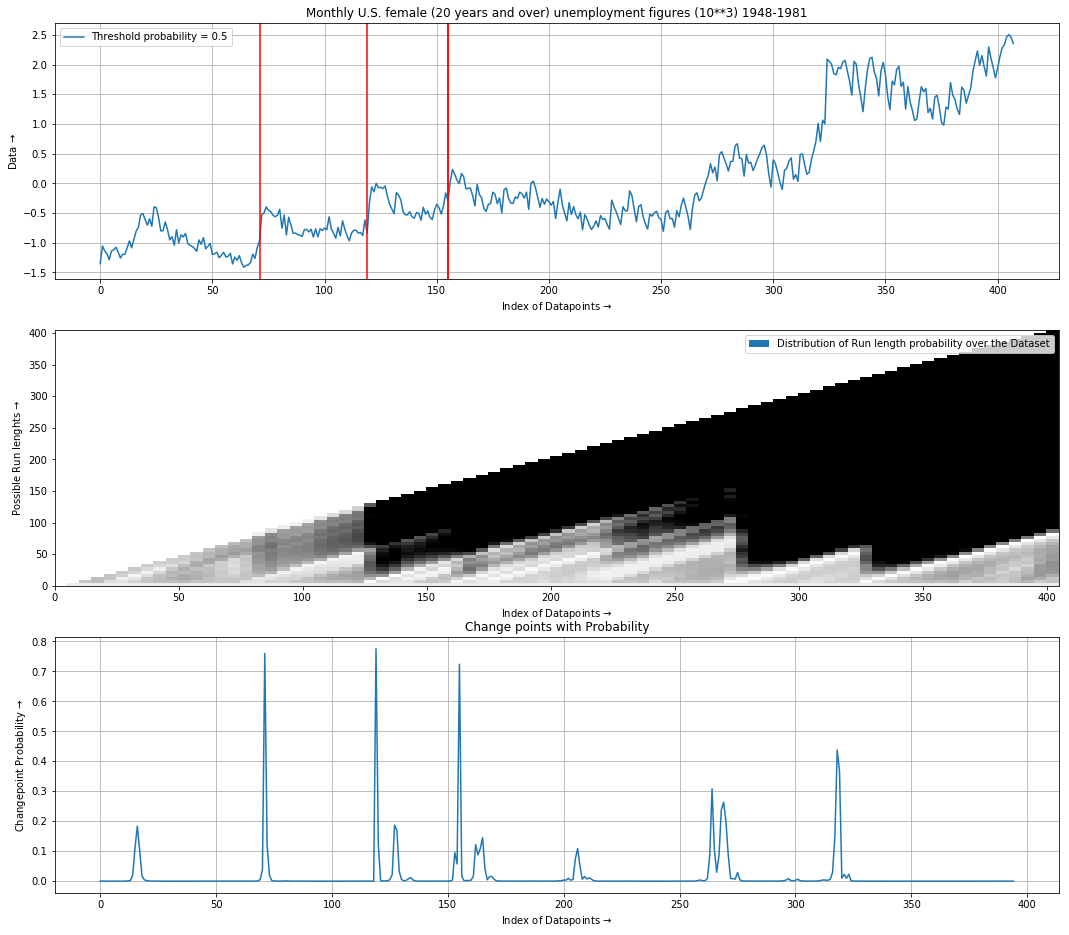


 No of Anomalies detected = 4
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "A1", "anomalies": [{"name": "Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981", "datapoints": [{"from_timestamp": -507600000000, "to_timestamp": -507600000000, "anomaly_timestamp": [-507600000000], "anomaly_code": "bcp"}, {"from_timestamp": -381369600000, "to_timestamp": -381369600000, "anomaly_timestamp": [-381369600000], "anomaly_code": "bcp"}, {"from_timestamp": -286675200000, "to_timestamp": -286675200000, "anomaly_timestamp": [-286675200000], "anomaly_code": "bcp"}, {"from_timestamp": -286675200000, "to_timestamp": -286675200000, "anomaly_timestamp": [-286675200000], "anomaly_code": "bcp"}]}]}]}

Detecting anomalies for alcohol-demand-log-spirits-consu.csv

Data reader initialised 

Getting the dataset from the reader....

Overview of data : 
               assetno  \
timestamp                
-3147897600000      A1   
-3137356800000      A1   
-312681600000

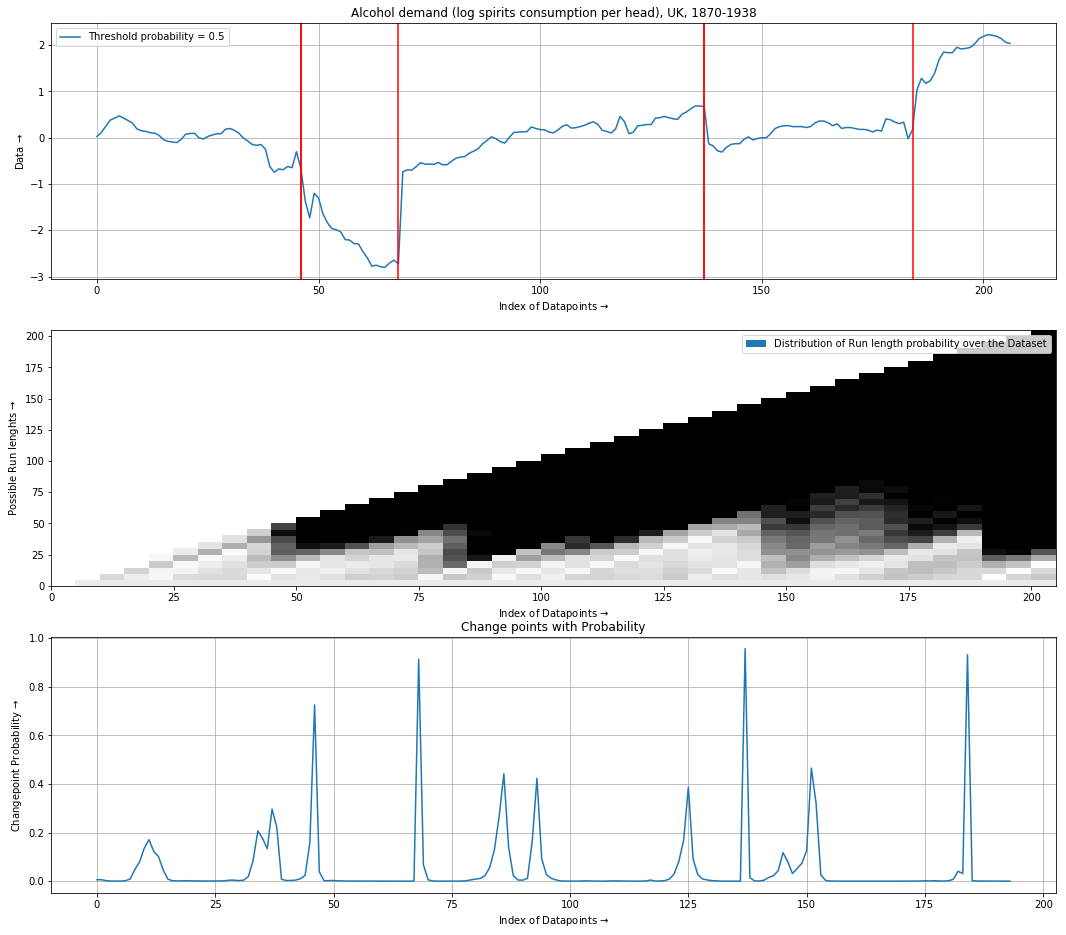


 No of Anomalies detected = 6
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "A1", "anomalies": [{"name": "Alcohol demand (log spirits consumption per head), UK, 1870-1938", "datapoints": [{"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2663971200000, "to_timestamp": -2663971200000, "anomaly_timestamp": [-2663971200000], "anomaly_code": "bcp"}, {"from_timestamp": -2432505600000, "to_timestamp": -2432505600000, "anomaly_timestamp": [-2432505600000], "anomaly_code": "bcp"}, {"from_timestamp": -1706832000000, "to_timestamp": -1706832000000, "anomaly_timestamp": [-1706832000000], "anomaly_code": "bcp"}, {"from_timestamp": -1706832000000, "to_timestamp": -1706832000000, "anomaly_timestamp": [-1706832000000], "anomaly_code": "bcp"}, {"from_timestamp": -1212451200000, "to_timestamp": -1212451200000, "anomaly_timestamp": [-1212451200000], "anomaly_code": "bcp"}]}]}]}


In [9]:
data_dir = '../../dataset/sample_csv_files/'
target_dir = '../../dataset/reader_csv_files/'
assetno = 'A1'
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    filepath,params = csv_helper.preparecsvtoread(filepath=infile,filename=filename,target_dir=target_dir,
                                                 assetno=assetno)
    
    algo_kwargs1 = algo_kwargs()
#     algo_kwargs1['thres_prob'] = 0.4
    res = main(**algo_kwargs1,filepath=filepath)
    print(res)

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets